# Step B - Multiple Instance Detection:
Material: 
Students are provided with two folders of images: 
 Models: contains one reference image for each product that the system should be able to identify. 
 Scenes: contains 15 different shelve picture to test the algorithm developed in different scenarios.  
Step A - Multiple Product Detection: 
Test on scene image: {e1.png, e2.png, e3.png, e4.png, e5.png} 
Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 26.jpg, 25.jpg}    Develop an object  detection system to identify single instance  of products given: one  reference  image  for 
each item and a scene image. The system should be able to correctly identify all the product in the shelves 
image. One way to solve this task could be the use of local invariant feature as explained in lab session 5.  
Step B - Multiple Instance Detection: 
Test on scene image: {m1.png, m2.png, m3.png, m4.png, m5.png} 
Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 26.jpg, 25.jpg} 
 
  In  addition  to what  achieved  at  step  A, the  system  should  now  be  able  to  detect  multiple  instance of  the 
same  product. Purposely, students may  deploy  local invariant  feature together with the GHT  (Generalized 
Hough Transform). More  precisely,  rather than relying on the usual R-Table,  the  object model acquired at 
training  time  should  now  consist  in  vectors  joining  all  the  features  extracted  in  the  model  image  to  their 
barycenter;  then,  at  run  time  all  the  image  features matched  with  respect  to the  model  would  cast  votes 
for the position of the barycenter by scaling appropriately the associated joining vectors (i.e. by the ratio of 
sizes between the matching features). 

In [5]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
import math

In [6]:
#convinience function
path_models = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","models")
path_scenes = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","scenes")

def get_path_model(index):
    return os.path.join(path_models, f"{index}.jpg")

def get_path_scene(index):
    return os.path.join(path_scenes, f"{index}")

#define color scene
#scene_color = cv.imread(get_path_scene("e3.png"))

#plt.imshow(cv.cvtColor(scene_color, cv.COLOR_RGB2BGR))
#plt.show()

In [7]:
def compare_pt(pt1, pt2):
    print("type", type(pt1))
    try:
        x1, y1 = pt1
        x2, y2 = pt2
        if x1 == x2 and y1 == y2:
            return True
        else:
            return False
    except Exception as e:
        print("An exception occurred:", e)
    #if isinstance(pt1,cv.KeyPoint) & isinstance(pt2,cv.KeyPoint)

Looking for 0.jpg...
Enough matches are found - 211/150


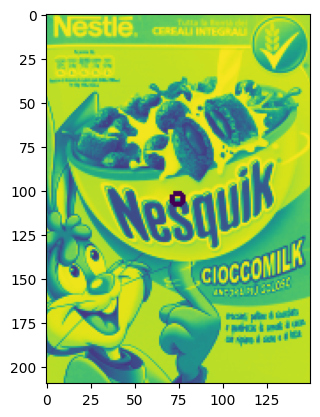

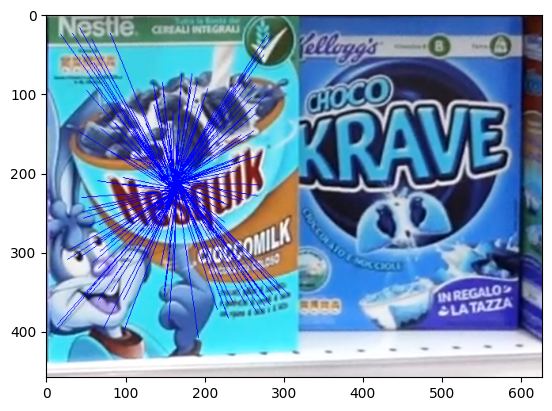

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'findHomography'
> Overload resolution failed:
>  - srcPoints is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'srcPoints'
>  - srcPoints is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'srcPoints'


In [16]:
def find_image(scene_path, model_paths, draw_on_color=True):
    target_resolution = (150, 210)
    scene_gray = cv.imread(scene_path,cv.IMREAD_GRAYSCALE)

    scene_to_draw_on = cv.imread(scene_path) if draw_on_color else scene_gray

    #create array with all models
    models = []
    for model_gray_path in model_paths:
        
        name = os.path.split(model_gray_path)[-1]
        models.append({
            "name": name,
            "img": cv.imread(model_gray_path, cv.IMREAD_GRAYSCALE)
            })

    for model in models:
        print(f"Looking for {model["name"]}...")

        _model_gray = model["img"]
        model_gray = cv.resize(_model_gray, target_resolution, interpolation=cv.INTER_AREA)
        MIN_MATCH_COUNT = 150

        # Initiate SIFT detector
        sift = cv.SIFT_create()

        # find the keypoints and descriptors with SIFTcv2.createGeneralizedHoughGuil
        kp_model, des_model = sift.detectAndCompute(model_gray,None)
        kp_scene, des_scene = sift.detectAndCompute(scene_gray,None)

        

        
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des_model,des_scene,k=2)

        # store all the good matches as per Lowe's ratio test.
        good = [] 
        for m,n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)

        
        #scene_to_draw_on = scene_to_draw_on if scene_to_draw_on is not None else scene_gray
        result = scene_to_draw_on
        
        if len(good)>MIN_MATCH_COUNT:
            print( "Enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            #src_pts = np.float32([ kp_model[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            #dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

            

            src_kp = [kp_model[m.queryIdx] for m in good]
            dst_kp = [kp_scene[m.trainIdx] for m in good]


            #calculate barycenter
            x = 0
            y = 0
            for kp in src_kp:
                x_kp, y_kp = kp.pt
                x += x_kp
                y += y_kp
            barycenter = np.array([int(x/len(src_kp)), int(y/len(src_kp))])

            #draw barycenter
            tmp = model_gray.copy()
            cv.circle(tmp, barycenter, 3, (0,0,255), 2)
            plt.imshow(tmp)
            plt.show() 

            # calculate joining vectors
            joining_vectors = []
            for kp in src_kp:
                x, y = kp.pt
                v = barycenter - [int(x), int(y)]
                joining_vectors.append(v)

            barycenter_votes = []

            tmp = scene_to_draw_on.copy()
            for s, d, jv in zip(src_kp, dst_kp, joining_vectors):
                
                if jv is None:
                    raise Exception("there must be the same point in")

                jv_x, jv_y = jv

                pt_x, pt_y = d.pt
                delta_s = d.size/s.size

                delta_phi = d.angle/s.angle

                angle_radians = math.radians(delta_phi)
                jv_x_rot = jv_x * math.cos(angle_radians) - jv_y * math.sin(angle_radians)
                jv_y_rot = jv_x * math.sin(angle_radians) + jv_y * math.cos(angle_radians)

                bary_predict = [int(pt_x + delta_s * jv_x_rot), int(pt_y + delta_s * jv_y_rot)]

                cv.line(tmp, bary_predict, [int(pt_x), int(pt_y)], (0,0,255), 1)
            
            plt.imshow(tmp)
            plt.show()

            # TODO: transform into src_pts form
            M, mask = cv.findHomography(src_kp, dst_kp, cv.RANSAC,5.0)
            matchesMask = mask.ravel().tolist()
            h,w = model_gray.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,
                                            h-1],[w-1,0] ]).reshape(-1,1,2)
            
            dst = cv.perspectiveTransform(pts,M)

            #add square and add text
            means = np.mean(dst, axis=0)
            x, y = [a for a in means[0]]
            x = x * 0.8 #adjust for text
            
            result = cv.polylines(scene_to_draw_on,[np.int32(dst)],True,255,3, cv.LINE_AA)

            boldness = 3
            size = 3
            cv.putText(scene_to_draw_on, model["name"], (int(x),int(y)), cv.FONT_HERSHEY_COMPLEX_SMALL, size, (0, 0, 255, 255), boldness, cv.LINE_AA)
        
        else:
            print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            matchesMask = None

    print("------------------------------------------")
    print("Results:")
    return result

#define models to be searched in image
models = [get_path_model(0)]
#[0,1,11,19,24,25,26]]

result = find_image(scene_path=get_path_scene("e1.png"),
                    model_paths=models,
                    draw_on_color=True
                    )

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

Looking for 0.jpg...
Not enough matches are found - 60/150
Looking for 1.jpg...
Not enough matches are found - 18/150
Looking for 2.jpg...
Not enough matches are found - 0/150
Looking for 3.jpg...
Not enough matches are found - 1/150
Looking for 4.jpg...
Not enough matches are found - 4/150
Looking for 5.jpg...
Not enough matches are found - 54/150
Looking for 6.jpg...
Not enough matches are found - 48/150
Looking for 7.jpg...
Not enough matches are found - 2/150
Looking for 8.jpg...
Not enough matches are found - 3/150
Looking for 9.jpg...
Not enough matches are found - 0/150
Looking for 10.jpg...
Not enough matches are found - 4/150
Looking for 11.jpg...
Not enough matches are found - 4/150
Looking for 12.jpg...
Not enough matches are found - 39/150
Looking for 13.jpg...
Not enough matches are found - 59/150
Looking for 14.jpg...
Not enough matches are found - 2/150
Looking for 15.jpg...
Not enough matches are found - 4/150
Looking for 16.jpg...
Not enough matches are found - 6/150
L

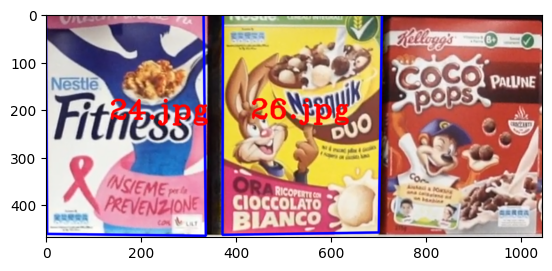

In [39]:
result = find_image(scene_path=get_path_scene("e2.png"),
                    model_paths=models,
                    draw_on_color=True
                    )

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

Looking for 0.jpg...
Enough matches are found - 194/150
Looking for 1.jpg...
Not enough matches are found - 106/150
Looking for 2.jpg...
Not enough matches are found - 2/150
Looking for 3.jpg...
Not enough matches are found - 1/150
Looking for 4.jpg...
Not enough matches are found - 6/150
Looking for 5.jpg...
Not enough matches are found - 49/150
Looking for 6.jpg...
Not enough matches are found - 68/150
Looking for 7.jpg...
Not enough matches are found - 7/150
Looking for 8.jpg...
Not enough matches are found - 1/150
Looking for 9.jpg...
Not enough matches are found - 3/150
Looking for 10.jpg...
Not enough matches are found - 17/150
Looking for 11.jpg...
Not enough matches are found - 91/150
Looking for 12.jpg...
Not enough matches are found - 7/150
Looking for 13.jpg...
Not enough matches are found - 8/150
Looking for 14.jpg...
Not enough matches are found - 3/150
Looking for 15.jpg...
Not enough matches are found - 4/150
Looking for 16.jpg...
Not enough matches are found - 3/150
Loo

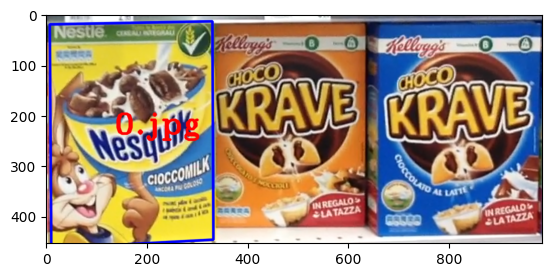

In [40]:
result = find_image(scene_path=get_path_scene("e3.png"),
                    model_paths=models,
                    draw_on_color=True
                    )

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

Looking for 0.jpg...
Enough matches are found - 175/150
Looking for 1.jpg...
Not enough matches are found - 120/150
Looking for 2.jpg...
Not enough matches are found - 3/150
Looking for 3.jpg...
Not enough matches are found - 0/150
Looking for 4.jpg...
Not enough matches are found - 3/150
Looking for 5.jpg...
Not enough matches are found - 50/150
Looking for 6.jpg...
Not enough matches are found - 61/150
Looking for 7.jpg...
Not enough matches are found - 4/150
Looking for 8.jpg...
Not enough matches are found - 0/150
Looking for 9.jpg...
Not enough matches are found - 3/150
Looking for 10.jpg...
Not enough matches are found - 17/150
Looking for 11.jpg...
Not enough matches are found - 113/150
Looking for 12.jpg...
Not enough matches are found - 5/150
Looking for 13.jpg...
Not enough matches are found - 4/150
Looking for 14.jpg...
Not enough matches are found - 3/150
Looking for 15.jpg...
Not enough matches are found - 4/150
Looking for 16.jpg...
Not enough matches are found - 5/150
Lo

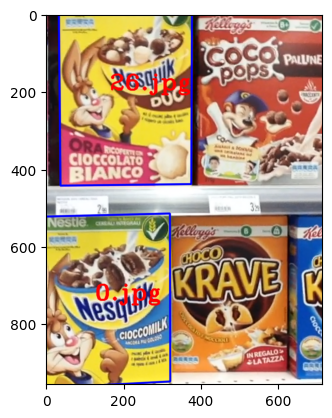

In [41]:
result = find_image(scene_path=get_path_scene("e4.png"),
                    model_paths=models,
                    draw_on_color=True
                    )

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

Looking for 0.jpg...
Not enough matches are found - 0/150
Looking for 1.jpg...
Not enough matches are found - 22/150
Looking for 2.jpg...
Not enough matches are found - 5/150
Looking for 3.jpg...
Not enough matches are found - 1/150
Looking for 4.jpg...
Not enough matches are found - 2/150
Looking for 5.jpg...
Not enough matches are found - 1/150
Looking for 6.jpg...
Not enough matches are found - 2/150
Looking for 7.jpg...
Not enough matches are found - 5/150
Looking for 8.jpg...
Not enough matches are found - 0/150
Looking for 9.jpg...
Not enough matches are found - 2/150
Looking for 10.jpg...
Not enough matches are found - 5/150
Looking for 11.jpg...
Not enough matches are found - 6/150
Looking for 12.jpg...
Not enough matches are found - 1/150
Looking for 13.jpg...
Not enough matches are found - 1/150
Looking for 14.jpg...
Not enough matches are found - 1/150
Looking for 15.jpg...
Not enough matches are found - 3/150
Looking for 16.jpg...
Not enough matches are found - 4/150
Lookin

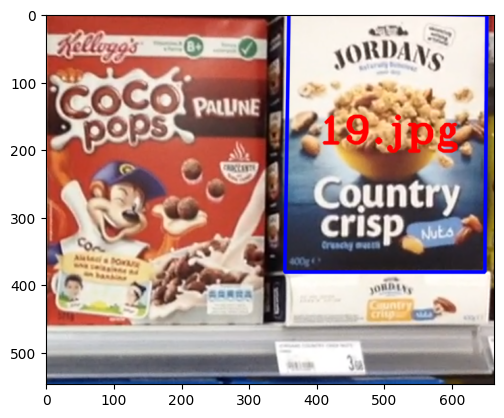

In [42]:
result = find_image(scene_path=get_path_scene("e5.png"),
                    model_paths=models,
                    draw_on_color=True
                    )

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()